In [1]:
import numpy as np
from quantecon.markov.approximation import rouwenhorst, tauchen
import matplotlib.pyplot as plt
from tabulate import tabulate
import jax
import jax.numpy as jnp
from pathlib import Path
PATH = Path('//bbking2.mit.edu/mbarrera/git_supply/14_462/recitation_2')
PATH = Path('/bbkinghome/mbarrera/git_supply/14_462/recitation_2')

# Rouwenwost vs Tauchen

In [2]:
def simulate_discrete_state(rho:float, sigma:float, method, n: int, T:int=1000)->np.ndarray:
    if method == 'rouwenhorst':
        markov = rouwenhorst(n = n,rho = rho, sigma = sigma)
    elif method == 'tauchen':
        markov = tauchen(n=n, rho = rho, sigma = sigma)
    states = markov.state_values
    probability = markov.P
    y = np.zeros(T)
    y[0] = np.random.choice(states, 1, p=markov.stationary_distributions.flatten())
    for t in range(T-1):
        y[t+1] = np.random.choice(states, 1, p=probability[states==y[t]].flatten())
    return y

def simulate_continuous_state(rho:float, sigma:float, T=1000)->np.ndarray:
    y = np.zeros(T)
    y[0] = np.random.normal(0,np.sqrt(sigma**2/(1-rho**2)))
    for t in range(T-1):
        y[t+1] = rho*y[t]+np.random.normal(0,sigma)
    return y

/tmp/ipykernel_2906266/1711351216.py:3: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  markov = rouwenhorst(n = n,rho = rho, sigma = sigma)
/tmp/ipykernel_2906266/1711351216.py:5: UserWarning: The API of tauchen has changed from `tauchen(rho, sigma_u, b=0., m=3, n=7)` to `tauchen(n, rho, sigma, mu=0., n_std=3)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  markov = tauchen(n=n, rho = rho, sigma = sigma)
/tmp/ipykernel_2906266/1711351216.py:3: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  markov = rouwenhorst(n = n,rho = rho, sigma = sigma)
/tmp/ipykernel_2906266/1711351216.py:5: UserWarning: The API of

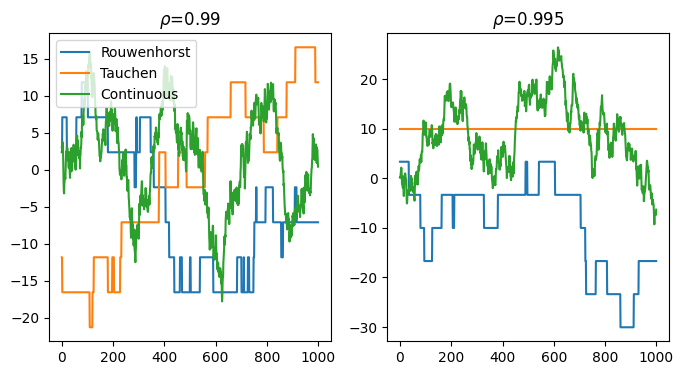

In [3]:
rho = [0.99, 0.995]
sigma=1
fig,ax= plt.subplots(ncols=2, figsize=(8,4))
for i in [0,1]:
    ax[i].plot(simulate_discrete_state(rho[i], sigma, 'rouwenhorst', n=10), label='Rouwenhorst')
    ax[i].plot(simulate_discrete_state(rho[i], sigma, 'tauchen', n=10), label='Tauchen')
    ax[i].plot(simulate_continuous_state(rho[i], sigma), label='Continuous')
    ax[i].set(title=fr'$\rho$={rho[i]}')
    if i==0:
        ax[i].legend()
fig.show()
fig.savefig(PATH / 'figures/discrete_ar1_approximation.pdf')

In [4]:
rho = 0.9
sigma = 1 
T=1000
n=50
print(tabulate([['Theoretical',round(sigma**2/(1-rho**2),3)],
                ['Rouwenhorst',round(np.var(simulate_discrete_state(rho, sigma, "rouwenhorst", n=n,T=T)),3)],
                ['Tauchen',round(np.var(simulate_discrete_state(rho, sigma, "tauchen", n=n,T=T)),3)]], headers=['Method','Variance']))

Method         Variance
-----------  ----------
Theoretical       5.263
Rouwenhorst       5.976
Tauchen           4.808


/tmp/ipykernel_2906266/1711351216.py:3: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  markov = rouwenhorst(n = n,rho = rho, sigma = sigma)
/tmp/ipykernel_2906266/1711351216.py:5: UserWarning: The API of tauchen has changed from `tauchen(rho, sigma_u, b=0., m=3, n=7)` to `tauchen(n, rho, sigma, mu=0., n_std=3)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  markov = tauchen(n=n, rho = rho, sigma = sigma)


# Ayiagari

In [5]:
phi = -5
beta = 0.99
r = 0
rho = 0.95
sigma = 0.1

/tmp/ipykernel_2906266/760958121.py:2: UserWarning: The API of rouwenhorst has changed from `rouwenhorst(n, ybar, sigma, rho)` to `rouwenhorst(n, rho, sigma, mu=0.)`. To find more details please visit: https://github.com/QuantEcon/QuantEcon.py/issues/663.
  markov = rouwenhorst(n = n_y,rho = rho, sigma = sigma)


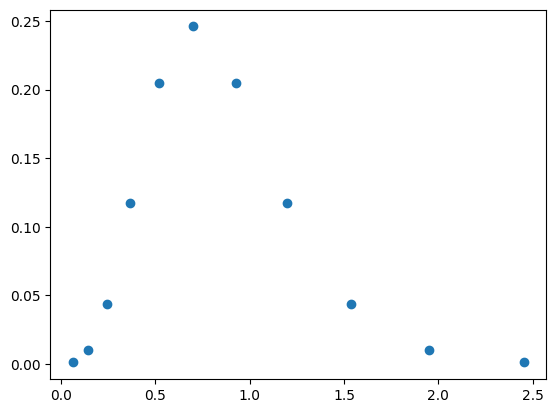

In [6]:
n_y = 11
markov = rouwenhorst(n = n_y,rho = rho, sigma = sigma)
y_states = jnp.exp(markov.state_values)-0.3
transition_matrix = markov.P

fig, ax = plt.subplots()
ax.scatter(y_states, markov.stationary_distributions.flatten())
fig.show()

# Grid Search

$$\begin{pmatrix}a_0&s_0\\
a_1&s_0\\
\vdots&\vdots\\
a_n&s_0\\
a_0&s_1\\
\vdots&\vdots\end{pmatrix}$$ 

Using `reshape(n_y, n_a)` we can get it:

$$\begin{pmatrix}(a_0,s_0)&(a_1,s_0)&\cdots\\
                                                  (a_0,s_1)&(a_1,s_1) &\\
                                                  \vdots& &\ddots\end{pmatrix}$$

In [7]:
n_a = 2000
A_max = 30
a_states=jnp.linspace(phi,A_max,n_a)

In [8]:
a_grid, y_grid = jnp.meshgrid(a_states, y_states)
#a_grid, y_grid = a_grid.reshape(-1,1),y_grid.reshape(-1,1)

In [9]:
def u(c):
    return jnp.where(c>0, jnp.log(c), -1e10)

In [10]:
def update_v(v_next, it):
    c = (1+r)*a_grid.reshape(-1,1)+y_grid.reshape(-1,1)-a_states.reshape(1,-1)
    v = jnp.max(u(c)+beta*jnp.repeat(transition_matrix@v_next,n_a, axis=0),axis=1,keepdims=True)
    v = v.reshape(n_y, n_a)
    return v, jnp.sum((v-v_next)**2), it+1

def get_policy_function(v_next):
    c = (1+r)*a_grid.reshape(-1,1)+y_grid.reshape(-1,1)-a_states.reshape(1,-1)
    policy = a_states[jnp.argmax(u(c)+beta*jnp.repeat(transition_matrix@v_next,n_a, axis=0),axis=1,keepdims=True)]
    return policy.reshape(n_y, n_a)

In [11]:
v0 = np.zeros_like(a_grid)

v, error, it = jax.lax.while_loop(cond_fun = lambda x: x[1]>1e-4, body_fun = lambda x: update_v(x[0],x[2]), init_val = (v0, 1,0))
print(f'Convergence in {it} iterations')
policy = get_policy_function(v)

Convergence in 861 iterations


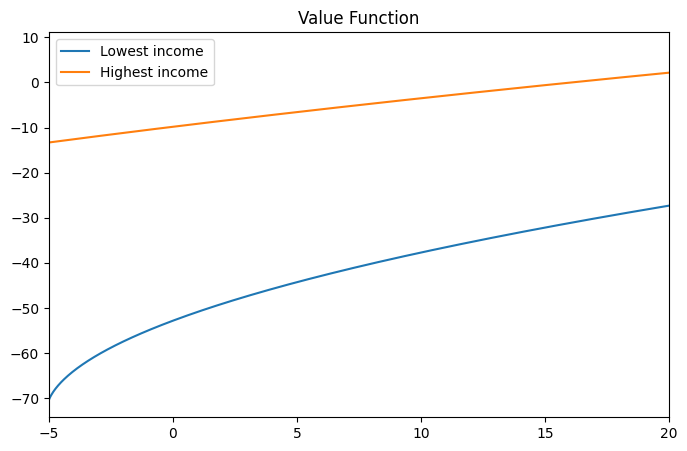

In [12]:
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(a_states, v[0], label='Lowest income')
ax.plot(a_states, v[-1], label='Highest income')
ax.legend()
ax.set(xlim=(phi,20),title='Value Function')
fig.show()
fig.savefig(PATH / 'figures/value_function.pdf')

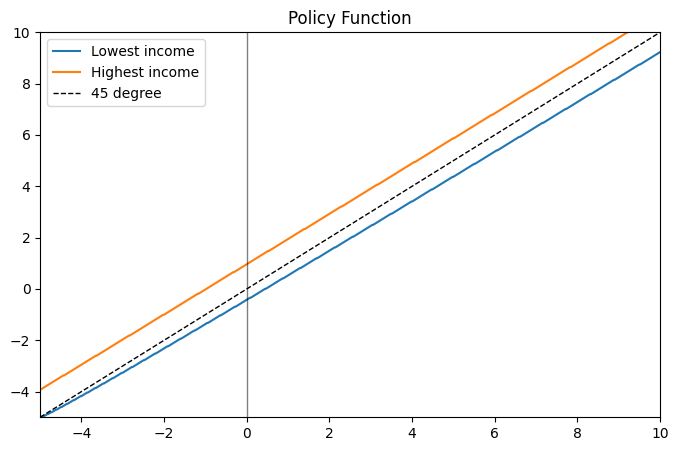

In [13]:
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(a_states, policy[0], label='Lowest income')
ax.plot(a_states, policy[-1], label='Highest income')
ax.plot(a_states, a_states, ls='--', c='k',lw=1,label='45 degree')
ax.legend()
ax.set(xlim=(phi,10),ylim=(phi,10),title='Policy Function')
ax.axvline(0,lw=1,c='k',alpha=0.5)
fig.show()
fig.savefig(PATH / 'figures/policy_function.pdf')

## Euler Residuals

In [14]:

def u_prime(c):
    return c**(-1)

def E(x,p):
    return jnp.dot(x.flatten(),p.flatten())

@jax.jit
def policy_interpolator(a, y, a_states, y_states, policy):
    a = jnp.atleast_1d(a)
    y = jnp.atleast_1d(y)
    if len(y)==1:
        return jnp.interp(a, 
                        a_states.flatten(), 
                        policy[jnp.searchsorted(y_states,y[0])])
    elif len(a)==1:
        return jax.vmap(lambda y: policy_interpolator(a, y, a_states, y_states, policy))(y).flatten()
    elif len(y)==len(a):
        return jax.vmap(lambda a,y: policy_interpolator(a, y, a_states, y_states, policy))(a, y).flatten()
    else:
        raise ValueError('a and y have to have the same length or be of lengh one')


@jax.jit
def euler_residual(a,y, a_next, transition_matrix, policy):
    c = (1+r)*a+y-a_next
    c_next = (1+r)*a_next+y_states+policy_interpolator(a_next, y_states, a_states, y_states, policy)
    return u_prime(c)+beta*E(u_prime(c_next), transition_matrix[jnp.searchsorted(y_states,y)])

In [15]:
euler_residual(1, y_states[3],1, transition_matrix, policy)

Array(3.2204516, dtype=float32)

In [16]:
def aux(a_next):
    return jax.vmap(lambda a,y, a_next: euler_residual(a,y,a_next, transition_matrix, policy))(a_grid.reshape(-1,1), y_grid.reshape(-1,1), a_next)

In [17]:
aux(a_grid.reshape(-1,1))

Array([[15.717335  ],
       [15.717158  ],
       [15.716804  ],
       ...,
       [ 0.42353728],
       [ 0.4235318 ],
       [ 0.42352754]], dtype=float32)

In [22]:
import sys

sys.path.append('/bbkinghome/mbarrera/git_supply/utils/jax_utils')
import jax_utils

In [24]:
jax_utils.root_scalar_vec_jax(aux, [jnp.ones_like(a_grid.reshape(-1,1))*phi,10])

{'d': Array([[7.776056e-11],
        [7.776056e-11],
        [7.776056e-11],
        ...,
        [7.776056e-11],
        [7.776056e-11],
        [7.776056e-11]], dtype=float32),
 'f1': Array([[-0.01570255],
        [-0.01578113],
        [-0.01585987],
        ...,
        [ 0.01454643],
        [ 0.01454111],
        [ 0.01453579]], dtype=float32),
 'f2': Array([[-0.01570255],
        [-0.01578113],
        [-0.01585987],
        ...,
        [ 0.1206086 ],
        [ 0.12058651],
        [ 0.12056446]], dtype=float32),
 'it': Array(51, dtype=int32, weak_type=True),
 'x1': Array([[9.999989],
        [9.999996],
        [9.99999 ],
        ...,
        [4.270508],
        [4.270508],
        [4.270508]], dtype=float32),
 'x2': Array([[9.999989],
        [9.999996],
        [9.99999 ],
        ...,
        [4.270508],
        [4.270508],
        [4.270508]], dtype=float32)}

In [305]:
@jax.jit
def solve_a_next(a,y, policy_grid):
    a_next = minimize(lambda a_next: euler_residual(a, y, a_next, transition_matrix, policy_grid)[0]**2,
                      x0 = jnp.atleast_1d(a), method="BFGS").x
    return a_next

@jax.jit
def iterate_policy(policy_grid):
    policy_grid =  jax.vmap(lambda a,y: solve_a_next(a,y,policy_grid))(a_grid.flatten(), y_grid.flatten())
    return policy_grid.reshape(n_y, n_a)

In [311]:
solve_a_next(a_states[3],y_states[4], policy_grid)

5.72 ms ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [312]:
iterate_policy(policy_grid)

2.69 s ± 47.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [314]:
len(a_grid.flatten())*0.005

55.0

In [250]:
#@jax.jit
def solve_a_next(a,y, policy_grid):
    a_next = minimize(lambda a_next: euler_residual(a, y, a_next, transition_matrix, policy_grid)[0]**2,
                      x0 = a, method="BFGS").x
    return a_next

#@jax.jit
def iterate_policy(policy_grid):
    policy_grid =  jax.vmap(lambda a,y: solve_a_next(a,y,policy_grid))(a_grid.flatten(), y_grid.flatten())
    return policy_grid.reshape(n_y, n_a)

In [251]:
iterate_policy(policy_grid)

Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = array([0.        , 0.00600601, 0.01201201, ..., 5.987988  , 5.993994  ,
       6.        ], dtype=float32)
  batch_dim = 0 Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = array([0.48409396, 0.48409396, 0.48409396, ..., 2.06571466, 2.06571466,
       2.06571466])
  batch_dim = 0 [[0.         0.         0.         ... 5.885886   5.891892   5.897898  ]
 [0.01201201 0.01801802 0.02402402 ... 5.921922   5.927928   5.933934  ]
 [0.07207207 0.07807808 0.08408409 ... 5.951952   5.957958   5.963964  ]
 ...
 [0.6846847  0.6906907  0.6966967  ... 6.         6.         6.        ]
 [0.8408409  0.8468469  0.8528529  ... 6.         6.         6.        ]
 [1.009009   1.015015   1.021021   ... 6.         6.         6.        ]]


IndexError: tuple index out of range

In [223]:
a = minimize(lambda a_next: euler_residual(a_states[3], y_states[3],a_next, transition_matrix, policy_grid)[0]**2,
                    x0 = a_states[3], method="BFGS")

In [224]:
a

OptimizeResults(x=Array([0.05210341], dtype=float32), success=Array(True, dtype=bool), status=Array(0, dtype=int32, weak_type=True), fun=Array(5.6136837, dtype=float32), jac=Array([-2.861023e-06], dtype=float32), hess_inv=Array([[0.0156208]], dtype=float32), nfev=Array(6, dtype=int32, weak_type=True), njev=Array(6, dtype=int32, weak_type=True), nit=Array(3, dtype=int32, weak_type=True))

In [216]:
from jax.scipy.optimize import minimize

In [22]:
foo = jax.vmap(lambda a,y,a_next: euler_residual(a,y, a_next, transition_matrix, policy_grid))(a_grid.flatten(),y_grid.flatten(),a_grid.flatten())

In [23]:
from recitation_2.jax_utils_f import goldsvec
from golden_vec import root_scalar_vec

root_scalar_vec(lambda a_next: jax.vmap(lambda a,y,a_next: euler_residual(a,y, a_next, transition_matrix, policy_grid))(a_grid.flatten(),y_grid.flatten(),a_next),
         bracket=[-phi, (1+r)*a_grid.flatten()+y_grid.flatten()-1e-3])

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [153]:

def root_scalar_vec(f: callable, bracket: tuple, tol=1e-10):
  """
  Find a root of a scalar function in a vectorized way
  
  Parameters
  ----------
  f: callable
  bracket: min and max. Iterable in the form of [min, max], where
  min and max can be either a float or an array.

  Returns
  -------
  RootResults
  """
  a = np.atleast_1d(bracket[0])
  b = np.atleast_1d(bracket[1])
  if len(a)==1 and len(b)>1:
    a = np.ones_like(len(b))*a
  elif len(b)==1 and len(a)>1:
    b = np.ones_like(len(a))*b    
  alpha1=(3-np.sqrt(5))/2
  alpha2=(np.sqrt(5)-1)/2
  d=b-a
  x1=a+alpha1*d
  x2=a+alpha2*d
  f1=f(x1)**2
  f2=f(x2)**2
  xx=np.zeros_like(x1)
  d=alpha1*alpha2*d
  it=0
  while np.max(d)>tol:
    d=d*alpha2
    if2bigger=f2>f1
    i1=np.asarray(if2bigger==1).nonzero()[0]
    i2=np.asarray(if2bigger==0).nonzero()[0]
    x2[i1]=x1[i1]
    x1[i1]=x1[i1]-d[i1]
    f2[i1]=f1[i1]
    x1[i2]=x2[i2]
    x2[i2]=x2[i2]+d[i2]
    f1[i2]=f2[i2]
    xx[i1]=x1[i1]
    xx[i2]=x2[i2]
    ff=f(xx)**2
    f1[i1]=ff[i1]
    f2[i2]=ff[i2]
    it+=1
    print({'x1':x1, 'x2':x2, 'f1':f1,'f2':f2, 'xx':xx})
    if it==2:
      break
  i2less=np.asarray(f2<f1).nonzero()[0]
  x1[i2less]=x2[i2less]
  f1[i2less]=f2[i2less]
  print(x1, x2)
  return None


In [2]:
def root_scalar_vec_jax(f: callable, bracket: tuple, tol=1e-10):
  """
  Find a root of a scalar function in a vectorized way
  
  Parameters
  ----------
  f: callable
  bracket: min and max. Iterable in the form of [min, max], where
  min and max can be either a float or an array.

  Returns
  -------
  RootResults
  """
  a = jnp.atleast_1d(bracket[0])
  b = jnp.atleast_1d(bracket[1])
  #if len(a)==1 and len(b)>1:
  #  a = np.ones_like(len(b))*a
  #elif len(b)==1 and len(a)>1:
  #  b = np.ones_like(len(a))*b    
  alpha1 = (3-jnp.sqrt(5))/2
  alpha2 = (jnp.sqrt(5)-1)/2
  d = b-a
  x1 = a+alpha1*d
  x2 = a+alpha2*d
  f1 = f(x1)**2
  f2 = f(x2)**2
  d = alpha1*alpha2*d
  it = 0
  iteration_state = {'d':d,'x1':x1,'x2':x2,'f1':f1,'f2':f2}
  def inner_loop(iteration_state, it):
    x1, x2 = iteration_state['x1'], iteration_state['x2']
    f1, f2 = iteration_state['f1'], iteration_state['f2']
    d = iteration_state['d']*alpha2
    idx = f2>f1
    new_state = dict(iteration_state)
    new_state['d'] = iteration_state['d']*alpha2
    new_state['x2'] = jnp.where(idx, x1,x2+d)
    new_state['x1'] = jnp.where(idx, x1-d,x2)
    xx = jnp.where(idx, new_state['x1'], new_state['x2'])
    ff = f(xx)**2
    new_state['f1'] = jnp.where(idx, ff, f2)
    new_state['f2'] = jnp.where(idx, f1, ff)
    it+=1
    return new_state, it
  

  return jax.lax.while_loop(cond_fun = lambda x: x[1]<100, 
                            body_fun = lambda x: inner_loop(x[0],x[1]), 
                            init_val = (iteration_state,0))

  return None
# while np.max(d)>tol:
#     d=d*alpha2
#     if2bigger=f2>f1
#     i1=np.asarray(if2bigger==1).nonzero()[0]
#     i2=np.asarray(if2bigger==0).nonzero()[0]
#     x2[i1]=x1[i1]
#     x1[i1]=x1[i1]-d[i1]
#     f2[i1]=f1[i1]
#     x1[i2]=x2[i2]
#     x2[i2]=x2[i2]+d[i2]
#     f1[i2]=f2[i2]
#     xx[i1]=x1[i1]
#     xx[i2]=x2[i2]
#     ff=f(xx)**2
#     f1[i1]=ff[i1]
#     f2[i2]=ff[i2]
#     it+=1
#   i2less=np.asarray(f2<f1).nonzero()[0]
#   x1[i2less]=x2[i2less]
#   f1[i2less]=f2[i2less]
#   return None
  #if np.max(f(x1)**2)>1e-10:
  #  return RootResults(root=x1, iterations=it, function_calls=it, flag=1)
  #return RootResults(root=x1, iterations=it, function_calls=it, flag=0)

In [4]:
root_scalar_vec_jax(lambda x: (x-jnp.array([1,2,3])), bracket=[-jnp.array([10,10,10]),jnp.array([10,10,10])])

NameError: name 'jnp' is not defined

In [141]:
euler_residual(a_states[3],y_states[3],3, transition_matrix)

Array([-0.30604973], dtype=float32)

In [152]:
(1+r)*a_grid.flatten()+y_grid.flatten()-1e-3

array([0.48309396, 0.48928015, 0.49546634, ..., 8.232342  , 8.23852848,
       8.24471449])

In [107]:
policy_interpolator([2,4], y_states[[2,3]], a_states, y_states, policy_grid=policy)

Array([[2.06006  ],
       [4.0900903]], dtype=float32)

In [80]:
len(y_states[[3]])

1

In [81]:
len(4.3)

TypeError: object of type 'float' has no len()

In [77]:
isinstance(y_states[3],float)

True

In [73]:
y_states[[3,4]]

array([0.74812104, 0.8649399 ])

In [26]:
a  = a_states[4]
y = y_states[4]

In [27]:
a_next = 0

In [61]:
u_prime((1+r)*a+y-a_next)+beta*E(u_prime((1+r)*a_next+y_states+jnp.interp(a_next, y_states, a_policy[[a_]] )), transition_matrix[jnp.where(y_states==y)].flatten())

Array([2.257707], dtype=float32)

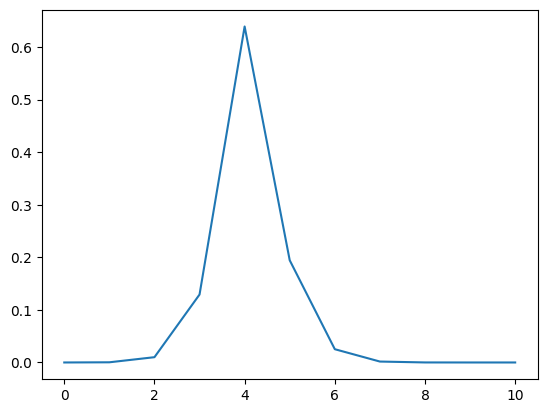

In [56]:
plt.plot(transition_matrix[jnp.where(y_states==y)].flatten())